In [1]:
import pandas as pd
from datetime import datetime
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
import math
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
np.random.seed(42)

In [3]:
gas_price = pd.read_excel('dzienne_ceny_gazu.xlsx')
crude_oil_price = pd.read_excel('dzienne_ceny_ropy.xlsx')
euro = pd.read_csv('eurpln_daily.csv')
dolar = pd.read_csv('usdpln_daily.csv')

### Przygotowanie danych

In [6]:
gas_price = gas_price[['Data', 'Zamknięcie']]
gas_price = gas_price.rename(columns={'Data' : 'Date', 'Zamknięcie' : 'Gas price'})
gas_price['Date'] =pd.to_datetime(gas_price['Date'], infer_datetime_format = True)
crude_oil_price = crude_oil_price[['Data', 'Zamknięcie']]
crude_oil_price = crude_oil_price.rename(columns={'Data' : 'Date', 'Zamknięcie' : 'Crude oil price'})
crude_oil_price['Date'] =pd.to_datetime(crude_oil_price['Date'], infer_datetime_format = True)
euro = euro[['Data','Zamkniecie']]
euro = euro.rename(columns={'Zamkniecie': 'Euro exchange rate', 'Data':'Date'})
euro['Date'] =pd.to_datetime(euro['Date'], infer_datetime_format = True)
dolar = dolar[['Data','Zamkniecie']]
dolar = dolar.rename(columns={'Zamkniecie': 'Dolar exchange rate', 'Data':'Date'})
dolar['Date'] =pd.to_datetime(dolar['Date'], infer_datetime_format = True)


In [7]:
final_daily_data = pd.merge(gas_price, crude_oil_price, how='outer', on=['Date','Date'])
final_daily_data = pd.merge(final_daily_data, euro, how='outer', on=['Date','Date'])
final_daily_data = pd.merge(final_daily_data, dolar, how='outer', on=['Date','Date'])

In [8]:
final_daily_data['Euro exchange rate'].backfill(inplace = True)
final_daily_data['Dolar exchange rate'].backfill(inplace = True)
final_daily_data['Crude oil price'].backfill(inplace = True)
final_daily_data['Crude oil price'].ffill(inplace = True)
final_daily_data['Gas price'].ffill(inplace = True)

In [9]:
final_daily_data = final_daily_data.set_index('Date')

In [10]:
final_daily_data = final_daily_data.sort_values('Date')

<AxesSubplot:>

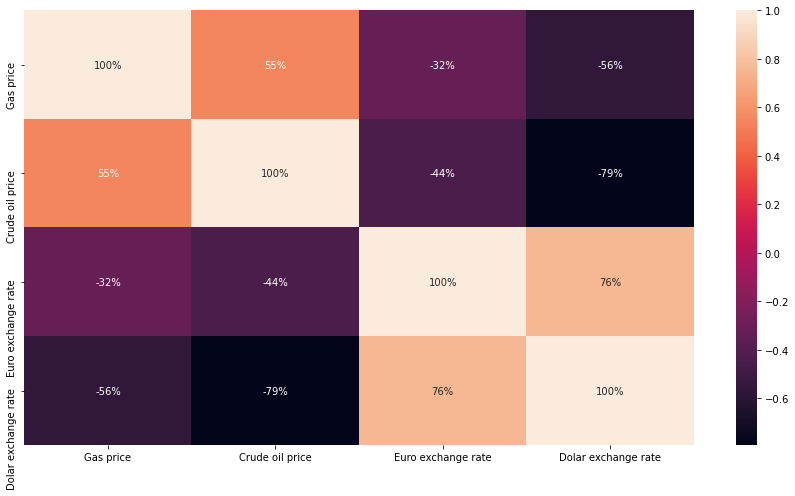

In [11]:
plt.figure(figsize=(15,8))  
sns.heatmap(final_daily_data.corr(), annot=True, fmt='.0%')

In [12]:
train_data = final_daily_data['2010-01-04': '2021-05-31']
test_data = final_daily_data['2021-06-01':]

In [30]:
scaler=MinMaxScaler()
scaled_data= scaler.fit_transform(train_data)
scaled_data

array([[0.90371477, 0.56771851, 0.29489161, 0.11388021],
       [0.87169086, 0.56678768, 0.31259219, 0.12312844],
       [0.93744663, 0.58177418, 0.3160143 , 0.12312844],
       ...,
       [0.30187874, 0.46420925, 0.78761668, 0.63173293],
       [0.30785653, 0.45974123, 0.77676032, 0.62722366],
       [0.61016225, 0.46532626, 0.77147375, 0.61912994]])

In [31]:
### 

In [32]:
X_train=[]
y_train=[]
for i in range(1,scaled_data.shape[0]):
    X_train.append(scaled_data[i-1:i])
    y_train.append(scaled_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(2950, 1, 4) (2950,)


## Model numer 4 - rekurencyjna sieć neuronowa GRU

In [33]:
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],4)))
model4.add(tf.keras.layers.Dropout(0.2))
model4.add(tf.keras.layers.GRU(units=50, return_sequences=True))
model4.add(tf.keras.layers.Dropout(0.2))
model4.add(tf.keras.layers.GRU(units=50, return_sequences=True))
model4.add(tf.keras.layers.Dropout(0.2))
model4.add(tf.keras.layers.GRU(units=50, return_sequences=False))
model4.add(tf.keras.layers.Dropout(0.2))
model4.add(tf.keras.layers.Dense(units=25))
model4.add(tf.keras.layers.Dense(units=1))


In [34]:
new_df4 =train_data.tail(1)
data = new_df4.append(test_data)


In [35]:
inputs4 = scaler.transform(data)

In [36]:
X_test=[]
y_test=[]
for i in range(1, inputs4.shape[0]):
    X_test.append(inputs4[i-1:i])
    y_test.append(inputs4[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape, y_test.shape)

(195, 1, 4) (195,)


In [37]:
model4.compile(optimizer='adam', loss='mean_squared_error')
early_stopping=EarlyStopping(monitor='loss', patience=10)
history=model4.fit(X_train, y_train,
                 epochs =200,
                 batch_size=32, validation_data=(X_test, y_test),
                 callbacks=[early_stopping])

Epoch 1/200
93/93 [==============================] - 6s 17ms/step - loss: 0.0278 - val_loss: 0.0507
Epoch 2/200
93/93 [==============================] - 1s 6ms/step - loss: 0.0059 - val_loss: 0.0168
Epoch 3/200
93/93 [==============================] - 1s 6ms/step - loss: 0.0049 - val_loss: 0.0093
Epoch 4/200
93/93 [==============================] - 1s 6ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 5/200
93/93 [==============================] - 1s 7ms/step - loss: 0.0045 - val_loss: 0.0088
Epoch 6/200
93/93 [==============================] - 1s 7ms/step - loss: 0.0043 - val_loss: 0.0051
Epoch 7/200
93/93 [==============================] - 1s 7ms/step - loss: 0.0042 - val_loss: 0.0091
Epoch 8/200
93/93 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0080
Epoch 9/200
93/93 [==============================] - 1s 8ms/step - loss: 0.0038 - val_loss: 0.0059
Epoch 10/200
93/93 [==============================] - 1s 8ms/step - loss: 0.0040 - val_loss: 0.0080
Epoch 11

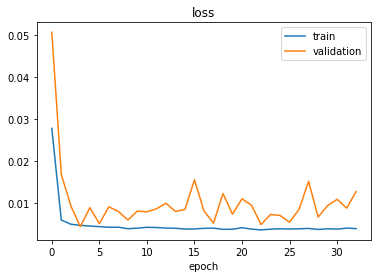

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='best')
plt.show()

In [39]:
y_pred = model4.predict(X_test)
scaler.scale_


array([0.21349274, 0.00930839, 1.18003847, 0.6044597 ])

In [40]:
scale=1/0.21349274
scale

4.684000027354561

In [41]:
y_pred = y_pred*scale
y_pred = pd.DataFrame(y_pred)
y_pred.rename(columns={0:'Predicted gas prices'}, inplace=True)


In [42]:
y_test = y_test*scale
y_test = pd.DataFrame(y_test)
y_test.rename(columns={0:'Actual gas prices'}, inplace=True)


In [43]:
MSE = math.sqrt(mean_squared_error(y_test, y_pred))
print('Mean squared error: ', MSE)
print('R2 Score : ', r2_score(y_test, y_pred))

Mean squared error:  0.5280519462723631
R2 Score :  0.5167706888638435


## Model numer 3 rekurencyjna sieć neuronowa LSTM

In [44]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],4)))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.LSTM(units=50, return_sequences=False))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(units=25))
model3.add(tf.keras.layers.Dense(units=1))

In [45]:
new_df3 =train_data.tail(1)
data = new_df3.append(test_data)
inputs3 = scaler.transform(data)
X_test=[]
y_test=[]
for i in range(1, inputs3.shape[0]):
    X_test.append(inputs3[i-1:i])
    y_test.append(inputs3[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape, y_test.shape)

(195, 1, 4) (195,)


In [46]:
model3.compile(optimizer='adam', loss='mean_squared_error')
early_stopping=EarlyStopping(monitor='loss', patience=10)
history=model3.fit(X_train, y_train,
                 epochs =200,
                 batch_size=32, validation_data=(X_test, y_test),
                 callbacks=[early_stopping])

Epoch 1/200
93/93 [==============================] - 6s 17ms/step - loss: 0.0452 - val_loss: 0.0726
Epoch 2/200
93/93 [==============================] - 1s 6ms/step - loss: 0.0087 - val_loss: 0.0378
Epoch 3/200
93/93 [==============================] - 1s 6ms/step - loss: 0.0051 - val_loss: 0.0072
Epoch 4/200
93/93 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0080
Epoch 5/200
93/93 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0067
Epoch 6/200
93/93 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0091
Epoch 7/200
93/93 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0058
Epoch 8/200
93/93 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0061
Epoch 9/200
93/93 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0055
Epoch 10/200
93/93 [==============================] - 0s 5ms/step - loss: 0.0039 - val_loss: 0.0064
Epoch 11

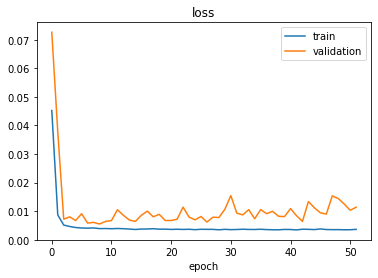

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='best')
plt.show()

In [48]:
y_pred = model3.predict(X_test)
scaler.scale_

array([0.21349274, 0.00930839, 1.18003847, 0.6044597 ])

In [49]:
scale=1/0.21349274
scale

4.684000027354561

In [50]:
y_pred = y_pred*scale
y_pred = pd.DataFrame(y_pred)
y_pred.rename(columns={0:'Predicted gas prices'}, inplace=True)

In [51]:
y_test = y_test*scale
y_test = pd.DataFrame(y_test)
y_test.rename(columns={0:'Actual gas prices'}, inplace=True)


In [52]:
MSE = math.sqrt(mean_squared_error(y_test, y_pred))
print('Mean squared error: ', MSE)
print('R2 Score : ', r2_score(y_test, y_pred))

Mean squared error:  0.4993014965549824
R2 Score :  0.5679582569769555
